In [1]:
import os
import cv2
import numpy as np
import random
import pickle

# Load images from a directory
def load_images_from_dir(directory):
    images = []
    labels = []
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith(".bmp"):
            img = cv2.imread(directory + "/" + filename, cv2.IMREAD_GRAYSCALE)
            images.append(img)
            labels.append(filename[:3])
            count += 1
    return images, labels

imgs, labels = load_images_from_dir("../Datasets/IITD Palmprint V1/Segmented/Left")

In [2]:
labels

['214',
 '108',
 '089',
 '031',
 '209',
 '115',
 '074',
 '150',
 '052',
 '176',
 '017',
 '133',
 '216',
 '008',
 '169',
 '152',
 '117',
 '015',
 '050',
 '194',
 '096',
 '028',
 '210',
 '013',
 '172',
 '056',
 '154',
 '070',
 '111',
 '035',
 '090',
 '192',
 '049',
 '128',
 '170',
 '135',
 '229',
 '037',
 '072',
 '092',
 '190',
 '037',
 '072',
 '170',
 '054',
 '135',
 '011',
 '212',
 '049',
 '192',
 '090',
 '154',
 '111',
 '013',
 '056',
 '149',
 '210',
 '028',
 '096',
 '194',
 '015',
 '131',
 '050',
 '174',
 '076',
 '152',
 '033',
 '117',
 '189',
 '230',
 '169',
 '216',
 '094',
 '196',
 '176',
 '133',
 '209',
 '031',
 '074',
 '089',
 '108',
 '069',
 '069',
 '214',
 '089',
 '017',
 '133',
 '052',
 '176',
 '074',
 '150',
 '031',
 '115',
 '094',
 '196',
 '008',
 '230',
 '189',
 '174',
 '131',
 '033',
 '076',
 '096',
 '194',
 '210',
 '149',
 '035',
 '154',
 '070',
 '172',
 '056',
 '137',
 '013',
 '212',
 '128',
 '049',
 '156',
 '113',
 '011',
 '229',
 '054',
 '190',
 '092',
 '092',
 '190',


In [3]:
from time import time

import matplotlib.pyplot as plt
from scipy.stats import loguniform

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

n_samples, h, w = len(imgs), imgs[0].shape[0], imgs[0].shape[1]

X = np.asarray(imgs, dtype="float32")
X = X.reshape((n_samples, -1))
n_features = X.shape[1]

y = np.asarray(labels, dtype="int64")
target_names = np.unique(y)
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1301
n_features: 22500
n_classes: 230


In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.asarray(imgs), labels, test_size=0.2, random_state=42, shuffle=True, stratify=labels)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 150, 150, 1))
x_test = x_test.reshape((len(x_test), 150, 150, 1))
np.save('/Users/gvssriram/Desktop/projects-internship/PalmGenAI/Datasets/IITD Palmprint V1/Preprocessed/Left/X_train.npy', x_train)
np.save('/Users/gvssriram/Desktop/projects-internship/PalmGenAI/Datasets/IITD Palmprint V1/Preprocessed/Left/X_test.npy', x_test)

In [5]:
x_train = x_train.reshape((len(x_train), -1))
x_test = x_test.reshape((len(x_test), -1))

x_train.shape

(1040, 22500)

In [6]:
n_components = 256

print("Extracting the top %d eigenpalm from %d palm" % (n_components, x_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(x_train)
print("done in %0.3fs" % (time() - t0))

eigenpalms = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenpalm orthonormal basis")
t0 = time()
X_train_pca = pca.transform(x_train)
X_test_pca = pca.transform(x_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 256 eigenpalm from 1040 palm
done in 2.079s
Projecting the input data on the eigenpalm orthonormal basis
done in 0.308s


In [7]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set


/Users/gvssriram/envs/bio_project_env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


done in 11.301s
Best estimator found by grid search:
SVC(C=8054.220823638732, class_weight='balanced', gamma=0.0009799889842553278)


In [8]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names.astype(str)))

Predicting people's names on the test set
done in 0.071s
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.50      1.00      0.67         1
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         1
           8       0.67      1.00      0.80         2
           9       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          14       1.00      1.00      1.00         1
          15       0.00      0.00      0.00         1
          16       0.50      1.00      0.67         1
          17       1.00 

/Users/gvssriram/envs/bio_project_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gvssriram/envs/bio_project_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/gvssriram/envs/bio_project_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [9]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


def title(predicted_label, true_label):
    return f"predicted: {predicted_label} \ntrue: {true_label}"


In [10]:
prediction_titles = [
    title(y_pred[i], y_test[i]) for i in range(y_pred.shape[0])
]

prediction_titles

['predicted: 206 \ntrue: 206',
 'predicted: 168 \ntrue: 168',
 'predicted: 094 \ntrue: 091',
 'predicted: 014 \ntrue: 014',
 'predicted: 116 \ntrue: 116',
 'predicted: 024 \ntrue: 024',
 'predicted: 227 \ntrue: 227',
 'predicted: 229 \ntrue: 229',
 'predicted: 156 \ntrue: 156',
 'predicted: 204 \ntrue: 039',
 'predicted: 015 \ntrue: 033',
 'predicted: 228 \ntrue: 228',
 'predicted: 080 \ntrue: 080',
 'predicted: 144 \ntrue: 144',
 'predicted: 184 \ntrue: 184',
 'predicted: 021 \ntrue: 224',
 'predicted: 049 \ntrue: 049',
 'predicted: 136 \ntrue: 136',
 'predicted: 112 \ntrue: 112',
 'predicted: 066 \ntrue: 066',
 'predicted: 165 \ntrue: 165',
 'predicted: 094 \ntrue: 047',
 'predicted: 195 \ntrue: 195',
 'predicted: 002 \ntrue: 133',
 'predicted: 070 \ntrue: 070',
 'predicted: 050 \ntrue: 050',
 'predicted: 042 \ntrue: 042',
 'predicted: 030 \ntrue: 098',
 'predicted: 102 \ntrue: 058',
 'predicted: 077 \ntrue: 077',
 'predicted: 023 \ntrue: 023',
 'predicted: 127 \ntrue: 127',
 'predic

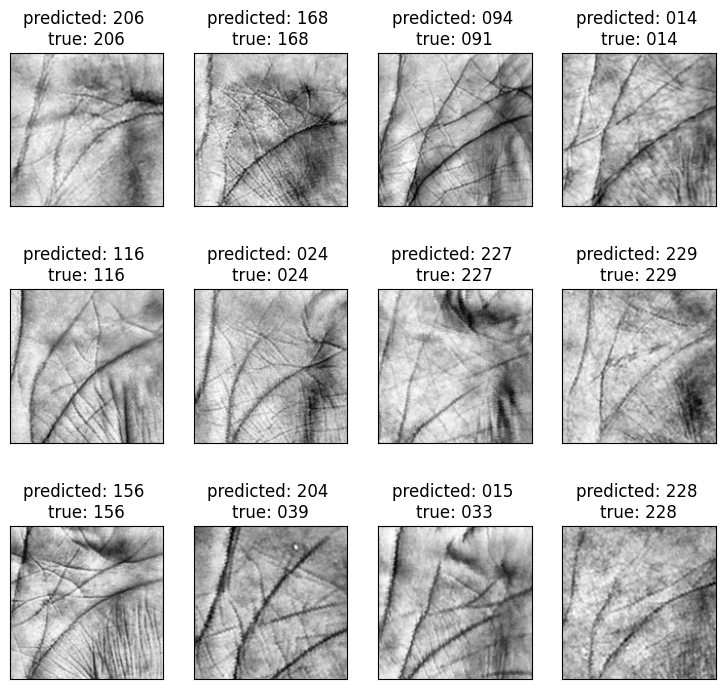

In [11]:
plot_gallery(x_test, prediction_titles, h, w)

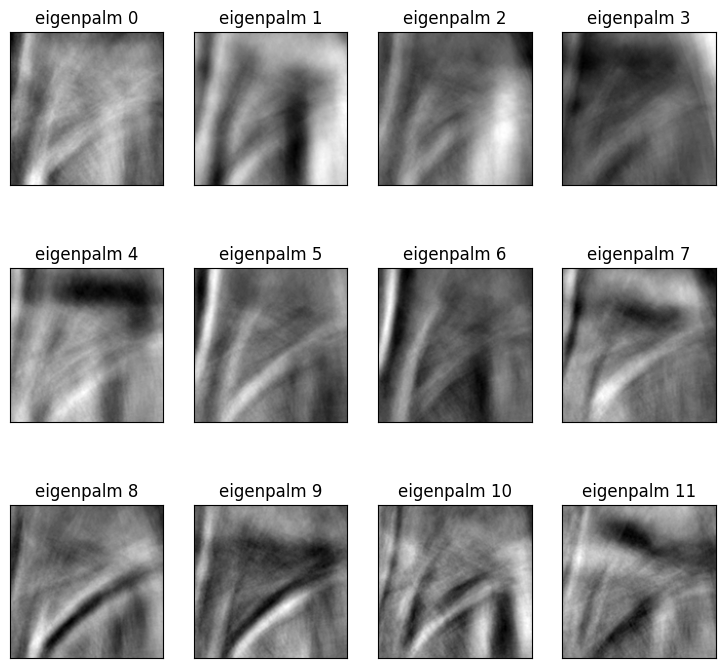

In [12]:
eigenface_titles = ["eigenpalm %d" % i for i in range(eigenpalms.shape[0])]
plot_gallery(eigenpalms, eigenface_titles, h, w)

plt.show()

In [13]:
X_train_pca.shape

(1040, 256)

In [14]:
np.save(f'../Datasets/IITD Palmprint V1/Preprocessed/Left/X_train_pca_{n_components}.npy', X_train_pca)
np.save(f'../Datasets/IITD Palmprint V1/Preprocessed/Left/X_test_pca.npy_{n_components}', X_test_pca)
np.save('../Datasets/IITD Palmprint V1/Preprocessed/Left/y_train.npy', y_train)
np.save('../Datasets/IITD Palmprint V1/Preprocessed/Left/y_test.npy', y_test)

In [15]:
np.save(f'../Datasets/IITD Palmprint V1/Preprocessed/Left/eigenpalms_{n_components}.npy', eigenpalms)
np.save(f'../Datasets/IITD Palmprint V1/Preprocessed/Left/target_names_{n_components}.npy', target_names)